In [1]:
from pathlib import Path
import utils
from typing import Callable
import scipy
import scipy.signal as sgn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
def filtered_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 5
    f_high = 40
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx


def naif_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    fft = np.fft.rfft(signal_matrix)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx

def calc_statistics(s):
    maxim = np.max(s, axis = 1)[:, np.newaxis]
    minim = np.min(s, axis = 1)[:, np.newaxis]
    mean = np.mean(s, axis = 1)[:, np.newaxis]
    
    mode = scipy.stats.mode(s, axis = 1)[0]
    
    return np.concatenate([maxim, minim, mean, mode], axis = 1)


In [3]:
def fft_neighbours(signal):
    N = signal.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 5
    f_high = 40
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)
    
    frq = np.fft.rfftfreq(N, dt)
    tf = abs(np.fft.rfft(sig_filt, axis = 1))
    
    #Interest Frequencies:
    interest_frq = [12.5, 16.5]
    harmonics = True
    bandwidth = 1.0
    
    mask = []
    selected_frq = []
    
    for f in frq:
        if any([int_f - bandwidth < f < int_f + bandwidth for int_f in interest_frq]):
            mask.append(True)
            selected_frq.append(f)
        elif harmonics and any([2*int_f - bandwidth < f < 2*int_f + bandwidth for int_f in interest_frq]):
            mask.append(True)
            selected_frq.append(f)
        else:
            mask.append(False)
        
    #print(selected_frq)
    
    return tf[:, mask]

In [4]:
class BCIDataset():
    def __init__(
        self, 
        csvs_path, 
        subject: str = 'all', 
        session: str = 'all',
        channel: str = 'all', 
        overlapping_fraction: float = 1/3, 
        window_size: int = 900,
        feature_extractor: Callable = naif_fft_features
    ):
        '''
        Object containing all examples from a time series from the dataset.
        Args:
            csvs_path (str): path al directorio donde estan los csv de los datos
            subject (str): sujeto a estudiar.
                Si se indica 'all' el dataset final generado tendrá ejemplos de todos los sujetos
            session (str): sesión a estudiar del sujeto seleccionado.
                si se indica 'all'  el dataset final generado tendrá ejemplos de todas las sesiones
            channel (str): 'ch0', 'ch1', 'ch2', 'ch3'. Si se indica 'all', los ejemplos serán la
                concatenación de los 4 canales.
            overlapping_fraction (float): porcentaje de desplazamiento de la "ventana" que hace el ejemplo
            window_size (int): tamaño de la ventana de tiempo que hace a un ejemplo (en muestras).
            feature_extractor (func): Función de extracción de features, le ingresa un arreglo
                (ejemplos en las filas, muestras en las columnas) y devuelve un arreglo (ejemplos en
                las filas y features en las columnas)
        '''
        self.csvs_path = Path(csvs_path)
        self.channel = channel
        self.parts = int(1 / overlapping_fraction)
        self.fraction = 1 / self.parts
        self.ws = window_size
        self.subject = subject
        self.session = session
        self.channels = ['ch0','ch1','ch2','ch3']
        self.feature_extractor = feature_extractor
        self.complete_dataset = utils.read_all_datasets(self.csvs_path)
        
        self.complete_examples_signal, self.complete_examples_features, \
        self.complete_labels, self.complete_metadata = \
            self.generate_examples()
        
    def generate_examples(self):
        # For each session generate the signal examples,
        # the feature extraction examples and labels arrays
        complete_examples_signal, complete_examples_features = [], []
        complete_labels, complete_metadata = [], []
        
        for subject in self.complete_dataset.subject.unique():
            # Just load the selected subject
            if self.subject != 'all' and subject != self.subject:
                continue
            sessions = \
                self.complete_dataset.loc[self.complete_dataset.subject==subject].session.unique()
            for session in sessions:
                # Just load the selected session
                if self.session != 'all' and session != self.session:
                    continue
                
                print(f'Processing subject: {subject} - session: {session}...')
                
                # Generate a subset of the dataset only with the desired rows
                selection = self.complete_dataset.loc[
                    (self.complete_dataset.subject==subject) &
                    (self.complete_dataset.session==session)
                ]
                
                # Standarize length of the array to a multiple to window size
                labels = selection.label.values
                n_rows = labels.shape[0] // self.ws
                labels = labels[: n_rows * self.ws]

                # Generate examples from the signal
                n_examples = n_rows * self.parts - (self.parts - 1)
                examples = np.empty((n_examples, self.ws))
                most_frec_labels = np.empty((n_examples, self.ws))
                times = np.empty((n_examples, self.ws))
                
                concat_ch_examples_signal, concat_ch_examples_features = [], []

                for k, ch in enumerate(self.channels):
                    # Use the four channels or just one
                    if self.channel != 'all' and self.channel != ch:
                        continue
                    
                    # Standarize length of the signal to a multiple to window size
                    signal = selection[ch].values
                    signal = signal[: n_rows * self.ws]
                    time = selection.time.values
                    time = time[: n_rows * self.ws]

                    # Increase the number of examples by overlapping the windows
                    for part in range(self.parts):
                        
                        # Find the place in the output array for each example
                        position = np.arange(part, n_examples, self.parts)
                        #position = position if part == 0 else position[:-part]

                        # Crop the signal according to the window size and overlap
                        start = int(self.ws / self.parts) * part
                        end = -int(self.ws - (self.ws / self.parts) * part)
                        end = end if part!=0 else signal.shape[0]
                        subset_signal = signal[start:end]
                        subset_labels = labels[start:end]
                        subset_times = time[start:end]

                        # Generate the examples
                        n_rows_ = int(subset_signal.shape[0]/self.ws)
                        examples[position, :] = subset_signal.reshape((n_rows_, self.ws))
                        most_frec_labels[position, :] = subset_labels.reshape((n_rows_, self.ws))
                        times[position, :] = subset_times.reshape((n_rows_, self.ws))
                    
                    # Obtain most frequent label
                    labels_ = scipy.stats.mode(most_frec_labels, axis=1).mode
                    labels_temp = scipy.stats.mode(most_frec_labels, axis=1).count
                    pureness = labels_temp == self.ws
                    # Get first and last time of the window
                    times_ = np.asarray([np.min(times, axis=1), np.max(times, axis=1)]).T
                    # Extract features
                    features = self.feature_extractor(examples)

                    concat_ch_examples_signal.append(examples.copy())
                    concat_ch_examples_features.append(features)

                concat_ch_examples_signal = np.concatenate(concat_ch_examples_signal, axis=1)
                concat_ch_examples_features = np.concatenate(concat_ch_examples_features, axis=1)

                complete_examples_signal.append(concat_ch_examples_signal)
                complete_examples_features.append(concat_ch_examples_features)
                complete_labels.append(labels_)
                lt = len(times_)
                metadata_ = np.concatenate(
                    [pureness, times_, np.repeat(subject, lt)[:,None], np.repeat(session, lt)[:,None]],
                    axis=1
                )
                complete_metadata.append(metadata_)

        complete_examples_signal = np.concatenate(complete_examples_signal)
        complete_examples_features = np.concatenate(complete_examples_features)
        complete_labels = np.concatenate(complete_labels)
        complete_metadata = np.concatenate(complete_metadata)
        
        return complete_examples_signal, complete_examples_features, complete_labels, complete_metadata
    
    def __len__(self):
        return self.complete_examples_signal.shape[0]
    
    def __getitem__(self, idx):
        return {
            'signal': self.complete_examples_signal[idx,:],
            'features': self.complete_examples_features[idx,:],
            'label': self.complete_labels[idx,:],
            'metadata': self.complete_metadata[idx,:]
        }

    def get_X_signal(self):
        return self.complete_examples_signal

    def get_X_features(self):
        return self.complete_examples_features

    def get_Y(self):
        return self.complete_labels

    def get_metadata(self):
        return self.complete_metadata


Para levantar los datasets desde txt o csv:
- Este notebook, o el notebook que usen que tenga la clase arriba definida, tiene que estar en el mismo directorio que el archivo utils.py, que tiene algunas funciones usadas en los métodos de la clase.
- Descarguen el .zip de la base de datos de nuevo y extraiganlos a un directorio llamado <path al repo en su máquina>/MentoriaBCI/Database/
- Definan el csvs_path acorde al directorio anterior:
    - csvs_path = '<PATH AL REPO>/MetoriaBCI/Database' ej: '/home/joaquin/Desktop/MentoriaDiploDatos/MetoriaBCI/Database'

# Recorrido por el código BCIDataset

In [5]:
csvs_path = '../../data'
dataset_neighbour = BCIDataset(
    csvs_path,
    subject='all',
    session='all',
    channel='all', 
    overlapping_fraction=1/8,
    window_size=512,
    feature_extractor=fft_neighbours
)

Processing subject: AA - session: 1...
Processing subject: AA - session: 0...
Processing subject: AA - session: 2...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: HA - session: 1...
Processing subject: MA - session: 1...


In [6]:
dataset_neighbour.complete_examples_features.shape

(10215, 84)

In [7]:
#Vemos que hay 84 valores, imprimiendo las selected frequencies podemos ver que frecuencias son, 
#pero también podemos repetirlo para generar más fácilmente la visualizacion del dataset en pandas
N = 512
frq = np.fft.rfftfreq(N, 1/200)

#Interest Frequencies:
interest_frq = [12.5, 16.5]
harmonics = True
bandwidth = 1.0

df_cols = []
selected_frq = []

i = 0 #le agregamos un indice para que no queden todos iguales.
for f in frq:
    for int_f in interest_frq:
        if int_f - bandwidth < f < int_f + bandwidth:
            df_cols.append(str(i) + "main" + str(interest_frq.index(int_f)+1))
            selected_frq.append(f)
            i+=1
        elif harmonics and 2*int_f - bandwidth < f < 2*int_f + bandwidth:
            df_cols.append(str(i) + "harm" + str(interest_frq.index(int_f)+1))
            selected_frq.append(f)
            i+=1
        else:
            pass

print(selected_frq)
print(df_cols)

[11.71875, 12.109375, 12.5, 12.890625, 13.28125, 15.625, 16.015625, 16.40625, 16.796875, 17.1875, 24.21875, 24.609375, 25.0, 25.390625, 25.78125, 32.03125, 32.421875, 32.8125, 33.203125, 33.59375, 33.984375]
['0main1', '1main1', '2main1', '3main1', '4main1', '5main2', '6main2', '7main2', '8main2', '9main2', '10harm1', '11harm1', '12harm1', '13harm1', '14harm1', '15harm2', '16harm2', '17harm2', '18harm2', '19harm2', '20harm2']


In [8]:
#Ahora respecto a las labels
print(dataset_neighbour.complete_labels.shape)

print((dataset_neighbour.complete_labels != 99)[:, 0])

(10215, 1)
[False False False ... False False False]


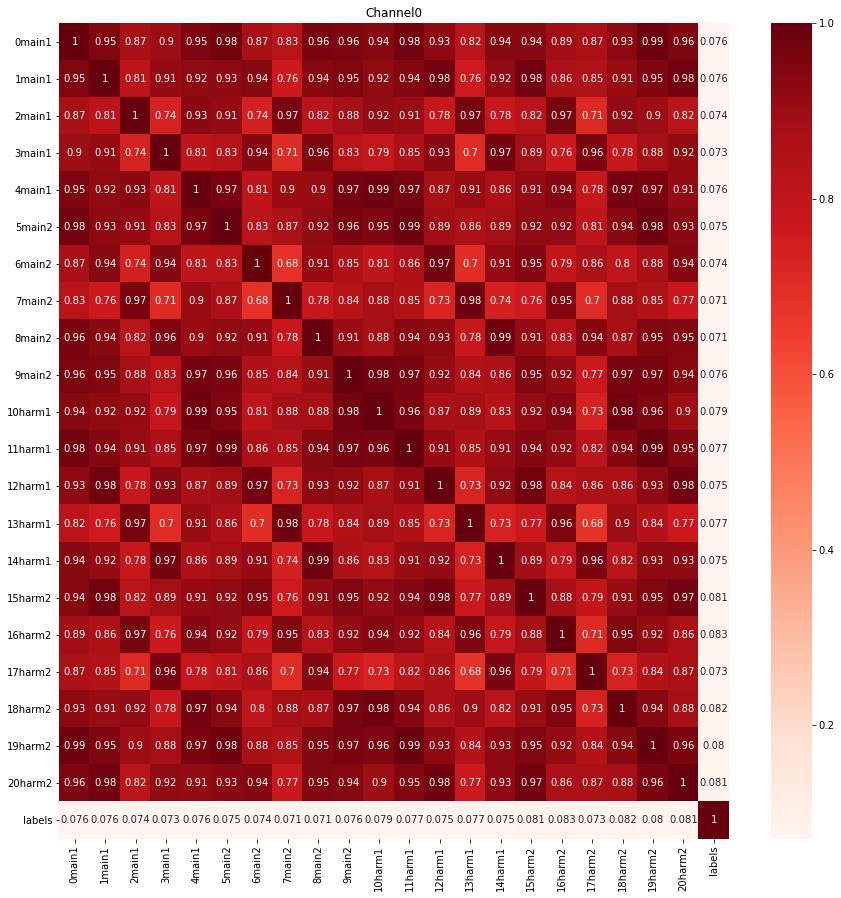

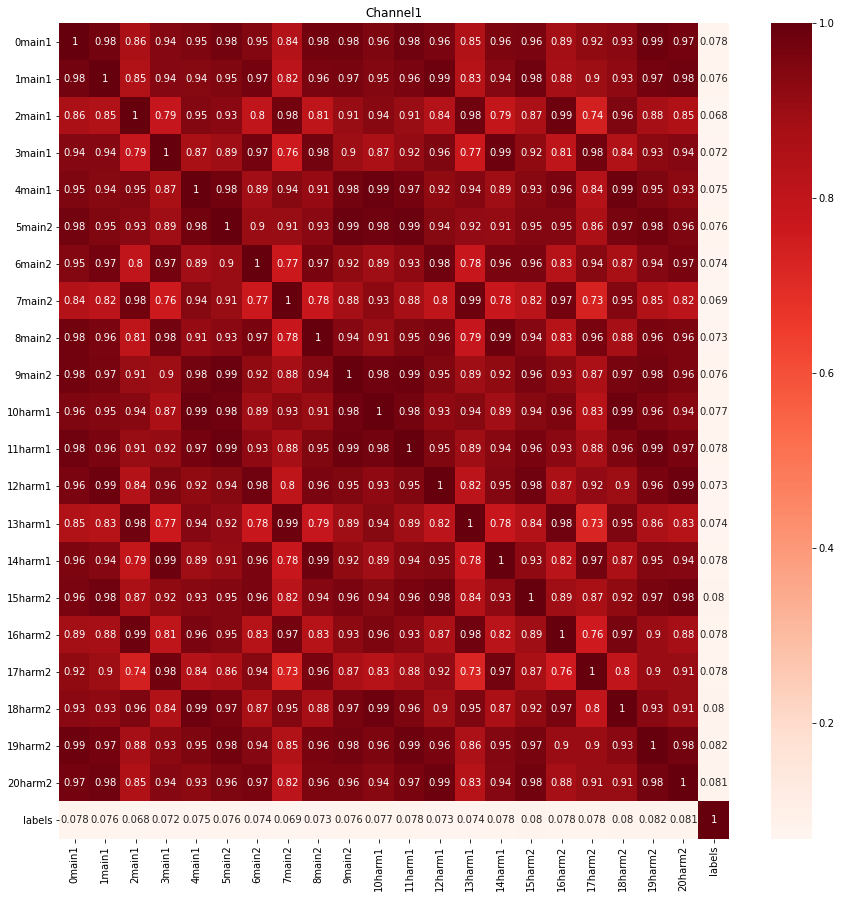

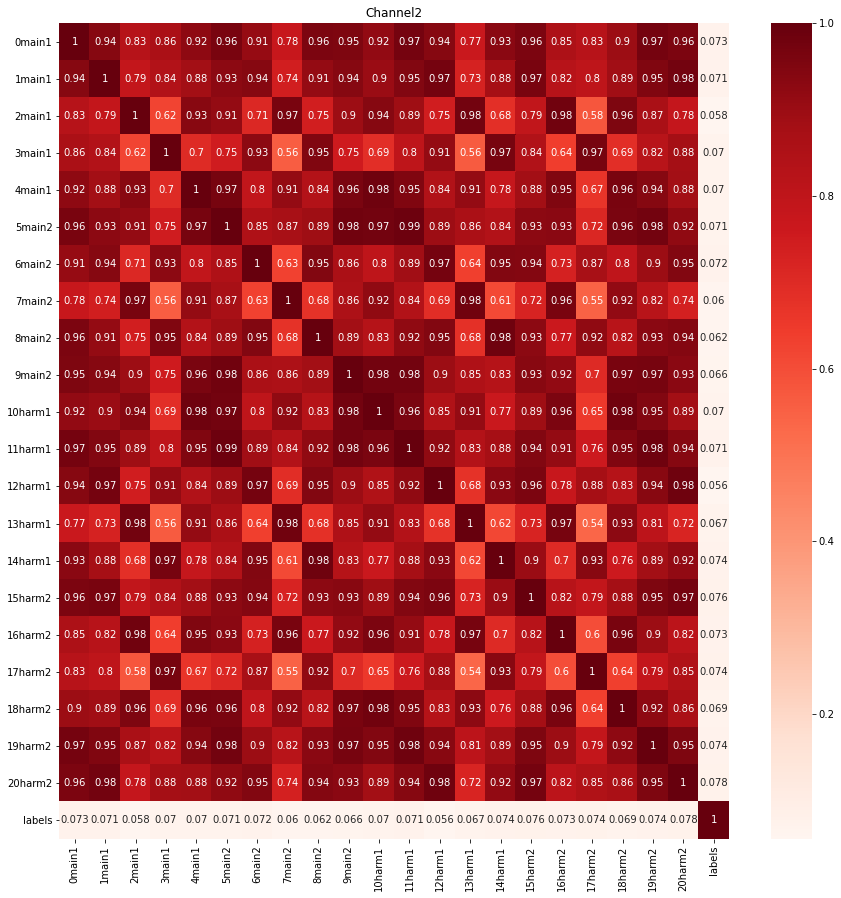

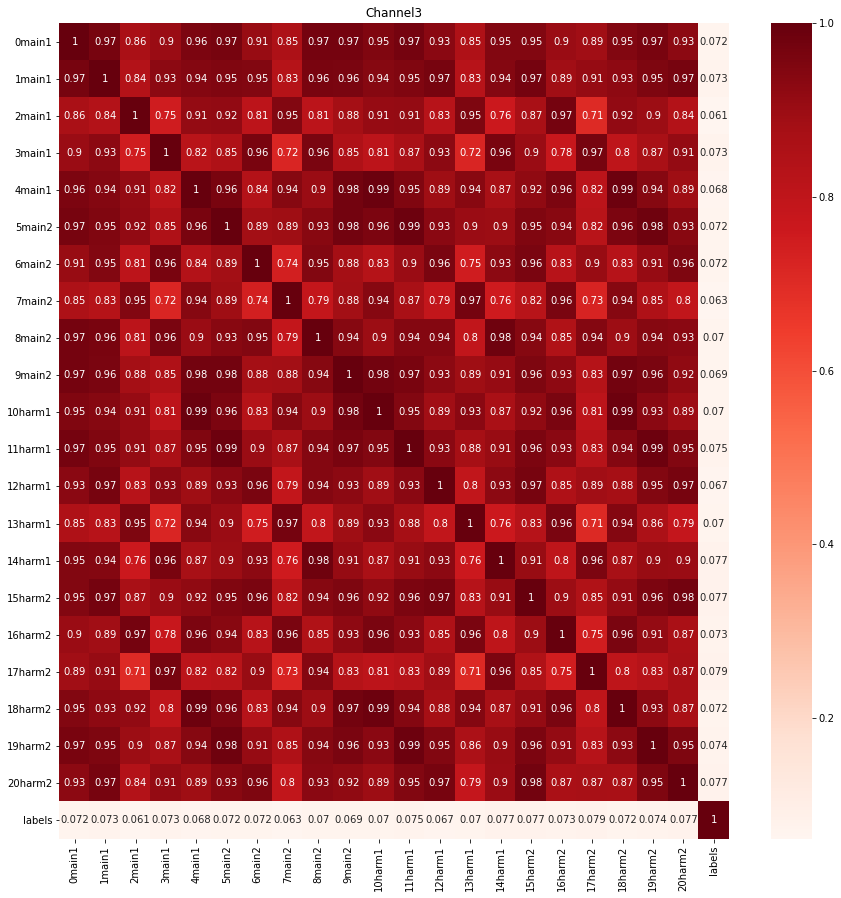

In [9]:
#Creemos el pandas para la correlación:

# COMENTAMOS LA MÁSCARA 99 PARA CONSERVAR ESE LABEL

labs = dataset_neighbour.complete_labels
#mask = (labs != 99)[:, 0]
#labs = labs[mask, :]
#labs = labs
feat = dataset_neighbour.complete_examples_features#[mask, :]
#feat = dataset_neighbour.complete_examples_features
ch_count = 0
for ch in range(0, feat.shape[1], feat.shape[1]//4):
    #print(ch, ":", ch + feat.shape[1]//4)
    corr_data = np.concatenate([feat[:, ch:ch+feat.shape[1]//4], labs], axis=1)
    corr_df = pd.DataFrame(corr_data, columns = df_cols + ["labels"])

    corr_table = corr_df.corr()

    plt.figure(figsize = (15, 15))
    sns.heatmap(corr_table, annot=True, cmap=plt.cm.Reds)
    #sns.heatmap(abs(corr_table), annot=True, cmap=plt.cm.Reds) #Si utilizan el valor absoluto, pueden observar claramente que valor de frecuencia dentro del array lleva la correlacion
    plt.title("Channel" + str(ch_count))
    plt.show()
    ch_count+=1

In [10]:
print(corr_df.shape)
print(corr_df.labels.unique())
corr_df.head()

(10215, 22)
[99.  2.  1.]


,0main1,1main1,2main1,3main1,4main1,5main2,6main2,7main2,8main2,9main2,...,12harm1,13harm1,14harm1,15harm2,16harm2,17harm2,18harm2,19harm2,20harm2,labels
0,1291.742254,682.768496,265.552767,172.702199,176.921330,230.978919,99.025301,118.316289,72.657041,324.665478,...,24.748377,112.236627,120.035553,32.200539,25.708034,85.455720,50.568216,85.398196,36.442760,99.0
1,961.678832,479.883790,163.717918,123.546170,119.077192,287.363210,221.405144,211.608896,177.936892,423.619958,...,78.893531,73.927322,74.087193,97.265990,90.505920,55.128175,103.484634,47.150823,94.313810,99.0
2,751.312440,171.560793,474.721527,317.258454,245.670032,239.688412,291.501969,246.428134,291.318484,524.137995,...,112.919850,158.674897,133.809419,207.579211,128.086927,63.835563,99.711399,103.753839,107.773377,99.0
3,647.413898,215.888118,538.604667,194.487540,52.096030,258.479670,453.334065,413.130441,138.948807,325.524007,...,177.822347,193.707391,71.570215,178.225977,85.808113,39.007592,156.654608,149.331268,81.895594,99.0
4,451.495345,400.226391,529.279373,58.815759,155.924986,279.994654,472.755345,368.699511,140.366308,390.914115,...,195.408249,152.108733,90.543034,73.769363,189.120202,142.389288,62.308766,114.105537,118.019719,99.0


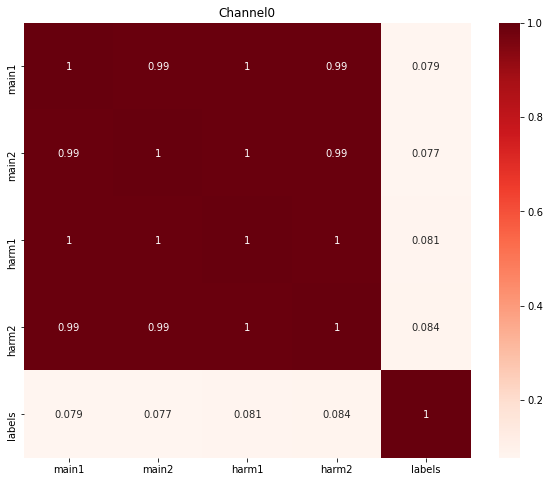

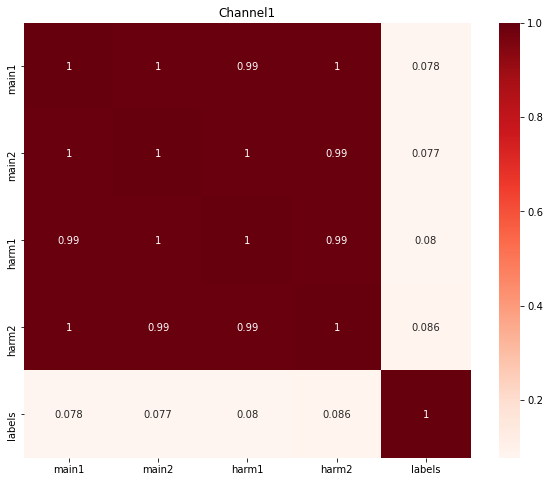

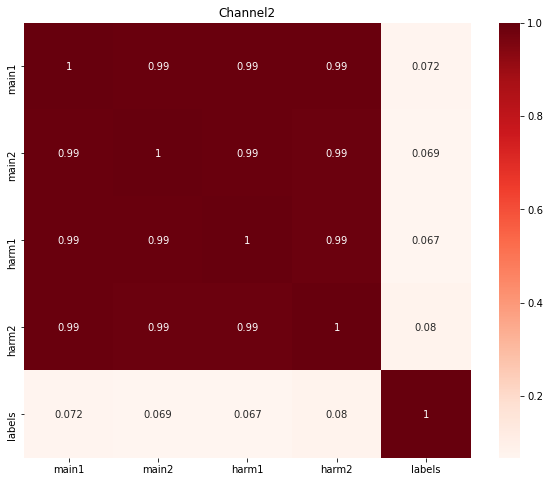

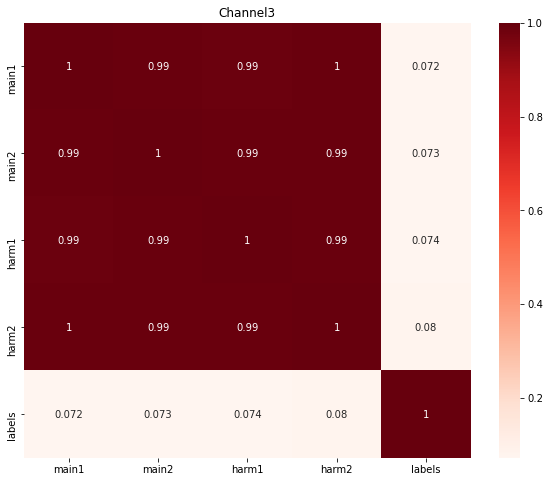

In [11]:
#medio a las apuradas, pero probemos de usar promedios entre los freq_neighbour
ch_count = 0
for ch in range(0, feat.shape[1], feat.shape[1]//4):
    avg_feat = []
    part_ch_feat = feat[:, ch:ch+feat.shape[1]//4]
    avg_feat.append(part_ch_feat[:, 0:5].max(axis=1)[:, np.newaxis]) #main1
    avg_feat.append(part_ch_feat[:, 5:10].max(axis=1)[:, np.newaxis]) #main2
    avg_feat.append(part_ch_feat[:, 10:15].max(axis=1)[:, np.newaxis]) #harm1
    avg_feat.append(part_ch_feat[:, 15:21].max(axis=1)[:, np.newaxis]) #harm2
    
    avg_feat = np.concatenate(avg_feat, axis = 1)
    
    corr_data2 = np.concatenate([avg_feat, labs], axis = 1)
    corr_df2 = pd.DataFrame(corr_data2, columns = ["main1", "main2", "harm1", "harm2", "labels"])
    
    corr_table2 = corr_df2.corr()

    plt.figure(figsize = (10, 8))
    sns.heatmap(corr_table2, annot=True, cmap=plt.cm.Reds)
    #sns.heatmap(abs(corr_table), annot=True, cmap=plt.cm.Reds) #Si utilizan el valor absoluto, pueden observar claramente que valor de frecuencia dentro del array lleva la correlacion
    plt.title("Channel" + str(ch_count))
    plt.show()
    ch_count+=1

In [12]:
print(corr_df2.shape)
print(corr_df2.labels.unique())
corr_df2.head()

(10215, 5)
[99.  2.  1.]


,main1,main2,harm1,harm2,labels
0,1291.742254,324.665478,126.818438,85.455720,99.0
1,961.678832,423.619958,118.180452,103.484634,99.0
2,751.312440,524.137995,189.450023,207.579211,99.0
3,647.413898,453.334065,193.707391,178.225977,99.0
4,529.279373,472.755345,195.408249,189.120202,99.0


In [13]:
# IMPORTANTE: Eliminar features que tengan alta correlación entre sí, 
# ya que suele mejorar las métricas de los modelos

# concatenamos ambos dfs
best_features = pd.concat([corr_df.drop('labels', axis=1, inplace=False), corr_df2], axis=1)
print(best_features.shape)
best_features.head()

(10215, 26)


,0main1,1main1,2main1,3main1,4main1,5main2,6main2,7main2,8main2,9main2,...,16harm2,17harm2,18harm2,19harm2,20harm2,main1,main2,harm1,harm2,labels
0,1291.742254,682.768496,265.552767,172.702199,176.921330,230.978919,99.025301,118.316289,72.657041,324.665478,...,25.708034,85.455720,50.568216,85.398196,36.442760,1291.742254,324.665478,126.818438,85.455720,99.0
1,961.678832,479.883790,163.717918,123.546170,119.077192,287.363210,221.405144,211.608896,177.936892,423.619958,...,90.505920,55.128175,103.484634,47.150823,94.313810,961.678832,423.619958,118.180452,103.484634,99.0
2,751.312440,171.560793,474.721527,317.258454,245.670032,239.688412,291.501969,246.428134,291.318484,524.137995,...,128.086927,63.835563,99.711399,103.753839,107.773377,751.312440,524.137995,189.450023,207.579211,99.0
3,647.413898,215.888118,538.604667,194.487540,52.096030,258.479670,453.334065,413.130441,138.948807,325.524007,...,85.808113,39.007592,156.654608,149.331268,81.895594,647.413898,453.334065,193.707391,178.225977,99.0
4,451.495345,400.226391,529.279373,58.815759,155.924986,279.994654,472.755345,368.699511,140.366308,390.914115,...,189.120202,142.389288,62.308766,114.105537,118.019719,529.279373,472.755345,195.408249,189.120202,99.0


## Aprendizaje Supervisado

**A) Benchmarking y desarrollo del algoritmo evaluador:**
       
**a)** Utilice una clasificación aleatoria de los ejemplos para utilizar como benchmark de los resultados posteriores. Este benchmark representa el peor de los desempeños de clasificación posibles.

**b)** Evalúe el desempeño/rendimiento de este benchmark bajo las métricas seleccionadas en el apartado anterior. Considere repetir este procesamiento algunas veces para obtener un promedio, máximo, mínimo u otro representante de estos resultados, ya que se trata de un proceso completamente aleatorizado.

In [14]:
best_features.labels.unique() 
# No estaban las etiquetas 99, comentamos la máscara más arriba, pero bajaron las correlaciones con los labels

array([99.,  2.,  1.])

**División en los conjuntos de train, test y validation**

In [15]:
X, y = best_features.iloc[:, :-1], best_features.labels

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y) # se queda con el 10% para validación
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train) # del 90% hace 20% para train y 80% para test

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Veamos la proporción del target (columna 'labels') en el dataset antes de la división:

In [17]:
y.value_counts()

99.0    6278
2.0     2034
1.0     1903
Name: labels, dtype: int64

Vemos que la proporción de la etiqueta '99' es casi 3 a 1 con respecto a las etiquetas '1' y '2'.

Chequeamos el desbalanceo en los conjuntos de train, test y val:

In [18]:
y_train.value_counts()

99.0    4520
2.0     1464
1.0     1370
Name: labels, dtype: int64

In [19]:
y_val.value_counts()

99.0    628
2.0     204
1.0     190
Name: labels, dtype: int64

In [20]:
y_test.value_counts()

99.0    1130
2.0      366
1.0      343
Name: labels, dtype: int64

Vemos que la proporción de la etiqueta '99' se mantiene casi 3 a 1 con respecto a las etiquetas '1' y '2', tanto en train, test y val.

### Scaling data

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

<IPython.core.display.Javascript object>

### Ancillary functions

In [22]:
def experiment(model, params, X_train, X_val, X_test):
    model_clf = model(**params)
    model_clf.fit(X_train, y_train)
    y_train_pred=model_clf.predict(X_train)
    y_val_pred = model_clf.predict(X_val)
    y_test_pred = model_clf.predict(X_test)
    clf_report_train = classification_report(y_train, y_train_pred)
    clf_report_val = classification_report(y_val, y_val_pred)
    clf_report_test = classification_report(y_test, y_test_pred)
    return model_clf, clf_report_train, clf_report_val, clf_report_test

def print_clf_reports(model, clf_report_train, clf_report_val, clf_report_test):
    set_dict = {
        'Train': clf_report_train, 
        'Val': clf_report_val, 
        'Test': clf_report_test
    }
    
    for key in set_dict:
        print("================================================================================")
        print("Model: ", str(model), " - " , key, " Clasification Report")
        print("================================================================================")
        print(set_dict[key])


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt
    

### Baseline model: Dumy Classifier

Como se espera de una estrategia uniforme, la distribución del target es aleatoria y no refleja la verdadera distribución de las etiquetas.

Para tener en cuenta el inconveniente mencionado anteriormente, podemos utilizar la estrategia "estratificada". Las predicciones se generan aleatoriamente, pero se mantiene la distribución de las clases del conjunto de entrenamiento. Al igual que en la estrategia estratificada train_test_split.

In [23]:
from sklearn.dummy import DummyClassifier

params = {
    'strategy':'stratified'
}

model = DummyClassifier
model_clf, clf_report_train, clf_report_val, clf_report_test = experiment(model, params, X_train, X_val, X_test)
print_clf_reports(model, clf_report_train, clf_report_val, clf_report_test)

Model:  <class 'sklearn.dummy.DummyClassifier'>  -  Train  Clasification Report
              precision    recall  f1-score   support

         1.0       0.19      0.18      0.19      1370
         2.0       0.19      0.18      0.19      1464
        99.0       0.61      0.62      0.61      4520

    accuracy                           0.45      7354
   macro avg       0.33      0.33      0.33      7354
weighted avg       0.45      0.45      0.45      7354

Model:  <class 'sklearn.dummy.DummyClassifier'>  -  Val  Clasification Report
              precision    recall  f1-score   support

         1.0       0.21      0.23      0.22       190
         2.0       0.18      0.17      0.18       204
        99.0       0.62      0.63      0.63       628

    accuracy                           0.46      1022
   macro avg       0.34      0.34      0.34      1022
weighted avg       0.46      0.46      0.46      1022

Model:  <class 'sklearn.dummy.DummyClassifier'>  -  Test  Clasification Report
 

In [46]:
print(clf_report_train)

              precision    recall  f1-score   support

         1.0       0.19      0.18      0.19      1370
         2.0       0.19      0.18      0.19      1464
        99.0       0.61      0.62      0.61      4520

    accuracy                           0.45      7354
   macro avg       0.33      0.33      0.33      7354
weighted avg       0.45      0.45      0.45      7354



**Métricas:**

- 'F1 Score' de cada clase.
- y el 'F1 Micro Score average'.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

- 'micro':
Calculate metrics globally by counting the total true positives, false negatives and false positives.

- 'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

- 'weighted':
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

- 'samples':
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

Los micro y macro promedios (para cualquier métrica) calcularán cosas ligeramente diferentes y, por lo tanto, su interpretación difiere. Un macro-promedio calculará la métrica independientemente para cada clase y luego tomará el promedio (por lo tanto, tratará a todas las clases por igual), mientras que un micro-promedio agregará las contribuciones de todas las clases para calcular la métrica promedio. En una configuración de clasificación de varias clases, es preferible el micro-promedio si sospecha que puede haber un desequilibrio de clase (es decir, puede tener muchos más ejemplos de una clase que de otras clases).

Ver:

https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2

https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1

**Comparemos las métricas obtenidas por un modelo baseline "Dummy Clasiffier", y otros modelos con sus parámetros por defecto.**

In [51]:
print('==========================================')
print('Baselines Models')
print('==========================================')
results = {
    'transformer0': [],
}

models = []
names = []


models.append(('Dummy Classifier', DummyClassifier(strategy='stratified')))
models.append(('Decission Tree', DecisionTreeClassifier()))
models.append(('XGBoost', XGBClassifier(eval_metric='mlogloss')))
models.append(('LightGBM', LGBMClassifier())) 
models.append(('Support Vector', SVC()))
models.append(('KNeighbors', KNeighborsClassifier())) 
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('Random Forest', RandomForestClassifier()))

for name, model in models:
    cv = StratifiedKFold(n_splits=5)
    
    print('')
    print(f'{name}')
    print('==========================================')
    
    cv_results_t0 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_micro')
    
    results['transformer0'].append(cv_results_t0) 

    names.append(name)

    print('F1 Score Micro mean: %.3f - ' % cv_results_t0.mean(), 'F1 Score Micro std: %.3f' % cv_results_t0.std())


Baselines Models


<IPython.core.display.Javascript object>


Dummy Classifier


<IPython.core.display.Javascript object>

F1 Score Micro mean: 0.451 -  F1 Score Micro std: 0.006


<IPython.core.display.Javascript object>


Decission Tree


<IPython.core.display.Javascript object>

F1 Score Micro mean: 0.614 -  F1 Score Micro std: 0.013


<IPython.core.display.Javascript object>


XGBoost


<IPython.core.display.Javascript object>

F1 Score Micro mean: 0.733 -  F1 Score Micro std: 0.004


<IPython.core.display.Javascript object>


LightGBM


<IPython.core.display.Javascript object>

F1 Score Micro mean: 0.736 -  F1 Score Micro std: 0.008


<IPython.core.display.Javascript object>


Support Vector


<IPython.core.display.Javascript object>

F1 Score Micro mean: 0.615 -  F1 Score Micro std: 0.000


<IPython.core.display.Javascript object>


KNeighbors


<IPython.core.display.Javascript object>

F1 Score Micro mean: 0.742 -  F1 Score Micro std: 0.009


<IPython.core.display.Javascript object>


Gradient Boosting


<IPython.core.display.Javascript object>

F1 Score Micro mean: 0.725 -  F1 Score Micro std: 0.007


<IPython.core.display.Javascript object>


Random Forest


<IPython.core.display.Javascript object>

F1 Score Micro mean: 0.734 -  F1 Score Micro std: 0.008


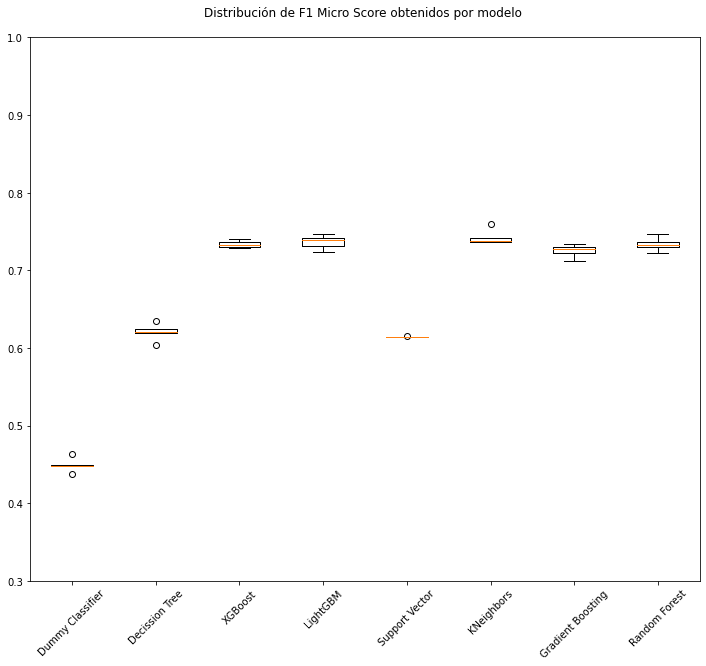

In [49]:
plt.figure(figsize=(12, 10))

for i in range(len(results)):
    #print(results[f'transformer{i}'])
    plt.boxplot(results[f'transformer{i}'], labels=names)
    plt.title(f"Distribución de F1 Micro Score obtenidos por modelo \n")
    plt.xticks(rotation=45)
    plt.ylim(0.3, 1)
    plt.show() 
print('')

**Ampliamos en los modelos que mejores resultados han dado.**

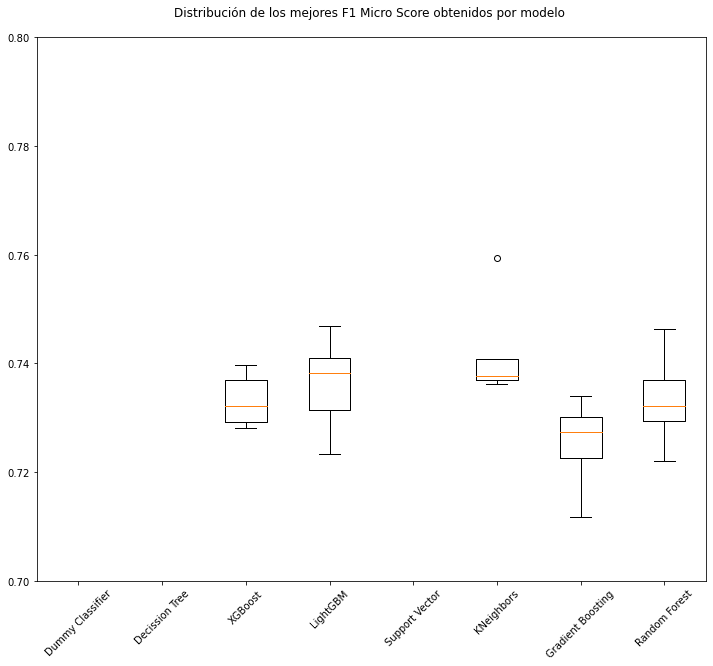

In [50]:
plt.figure(figsize=(12, 10))
for i in range(len(results)):
    #print(results[f'transformer{i}'])
    plt.boxplot(results[f'transformer{i}'], labels=names)
    plt.title(f"Distribución de los mejores F1 Micro Score obtenidos por modelo \n")
    plt.xticks(rotation=45)
    plt.ylim(0.7, 0.8)
    plt.show() 
print('')

In [ ]:
# Training Learning Curve
# Interpretation: 
# https://towardsdatascience.com/plotting-the-learning-curve-with-a-single-line-of-code-90a5bbb0f48a
for name, model in models:
    title = name
    estimator=model
    
    plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.5, 1.01),
                    cv=cv, n_jobs=4)

### B) Búsqueda a grandes rasgos:

**a)** Utilicen la mayor cantidad de algoritmos de aprendizaje automático supervisado que puedan (mínimo 3). Creen para cada uno un modelo bajo el paradigma de dicho método y entrénelo con el dataset elegido. Opcional:
generar curvas de progreso de métricas y funciones de pérdida a lo largo del entrenamiento.

**b)** No hace falta que la búsqueda de hiperparámetros extremadamente detallada, ya que esto se llevará a cabo en el inciso C), sino más bien una exploración general de las tendencias de cada modelo.

**c)** Si encuentra resultados de las métricas analizadas o gráficos de entrenamiento ploteados que resulten destacables -no sólo porque sean valores más óptimos, sino también posibles casos extraños, situaciones de
over y underfitting, etc- muéstrelos y analícelos en este inciso.

In [29]:
# Probar para los 4 mejores modelos correrlos con otros parámetros y plotear sus loss plots
# XGBoost: 'mlogloss plot' y 'merror plot'

¿Qué significa conceptualmente la pérdida logarítmica (logloss)?

La pérdida logarítmica indica lo cerca que está la probabilidad de predicción del valor real/verdadero correspondiente (1, 2, 99, en éste caso de clasificación multiclase). Cuanto más se aleje la probabilidad predicha del valor real, mayor será el valor de la pérdida logarítmica.

**Entrenaremos los modelos baselines que mejores resultados han dado:**

- XGBoost
- LGBM
- RandomForest
- KNN

**XGBoost**

In [ ]:
# VER DE EJECUTAR ÉSTO MISMO CON LAS FUNCIONES DEFINIDAS
# Y luego hacer el results = model_clf.evals_result()

In [53]:
eval_set = [(X_train, y_train), (X_val, y_val), (X_test, y_test)]
eval_metric = ["merror","mlogloss"]
model_clf = XGBClassifier()
model_clf.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, verbose=False)
results = model_clf.evals_result()
# validation_0 (Train) 
# validation_1 (Val)
# validation_2 (Test)

y_train_pred=model_clf.predict(X_train)
y_val_pred = model_clf.predict(X_val)
y_test_pred = model_clf.predict(X_test)
clf_report_train = classification_report(y_train, y_train_pred)
clf_report_val = classification_report(y_val, y_val_pred)
clf_report_test = classification_report(y_test, y_test_pred)

print_clf_reports(model, clf_report_train, clf_report_val, clf_report_test)

Model:  RandomForestClassifier()  -  Train  Clasification Report
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1370
         2.0       1.00      1.00      1.00      1464
        99.0       1.00      1.00      1.00      4520

    accuracy                           1.00      7354
   macro avg       1.00      1.00      1.00      7354
weighted avg       1.00      1.00      1.00      7354

Model:  RandomForestClassifier()  -  Val  Clasification Report
              precision    recall  f1-score   support

         1.0       0.73      0.62      0.67       190
         2.0       0.60      0.37      0.46       204
        99.0       0.74      0.87      0.80       628

    accuracy                           0.72      1022
   macro avg       0.69      0.62      0.64      1022
weighted avg       0.71      0.72      0.71      1022

Model:  RandomForestClassifier()  -  Test  Clasification Report
              precision    recall  f1-score   

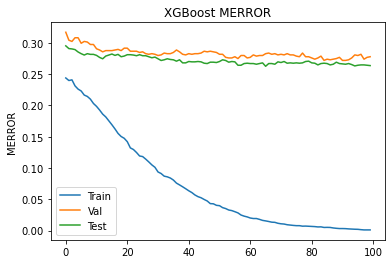

In [34]:
# XGBoost MERROR

epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Val')
ax.plot(x_axis, results['validation_2']['merror'], label='Test')
ax.legend()
plt.ylabel('MERROR')
plt.title('XGBoost MERROR')
plt.show()

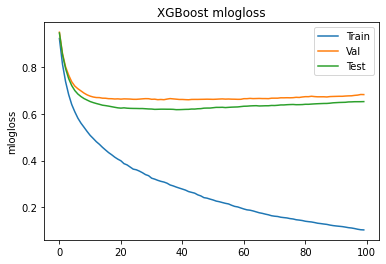

In [35]:
# XGBoost MLOGLOSS

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Val')
ax.plot(x_axis, results['validation_2']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('MLOGLOSS')
plt.title('XGBoost MLOGLOSS')
plt.show()

**[TODO]** Ver cómo se interpretan las curvas de 'merror' y 'mlogloss'.

Ver: https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/